In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import madmom
import mir_eval
from sklearn.model_selection import KFold

from modules.labels import get_label_vector
from modules.madmom_cnn_prep import cnn_preprocessor
from datasets import Dataset
from modules.analysis_funcs import get_idx_to_fold, get_segmented_data, get_test_peaks, aubio_peakpicker_do, aubio_postprocessing
from analyze_detection import evaluate
from modules.energy_based import legato_mg

%load_ext autoreload
%autoreload 2

FPS = 100
CONTEXT = 7

# Load Madmom normalization
def cnn_normalize(frames):
    inv_std = np.load("models/bock2013pret_inv_std.npy")
    mean = np.load("models/bock2013pret_mean.npy")
    frames_normalized = (frames - np.reshape(mean, (1,80,3)))*np.reshape(inv_std, (1,80,3))
    return frames_normalized

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

/usr/local/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.11) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [5]:
ds0 = Dataset("initslurtest")
ds1 = Dataset("slurtest_add_1")
ds2 = Dataset("slurtest_add_2")
ds3 = Dataset("slurtest_test")

audio_fnames = ds0.get_audio_paths() + ds1.get_audio_paths() + ds2.get_audio_paths() + ds3.get_audio_paths()
label_fnames = ds0.get_annotation_paths() + ds1.get_annotation_paths() + ds2.get_annotation_paths() + ds3.get_annotation_paths()

audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
onset_schedules = [np.loadtxt(label_fname, usecols=0) for label_fname in label_fnames]

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [6]:
# Dataset info
audio_lengths_sec = [len(audio)/sr for audio,sr in zip(audios, sample_rates)]
iois = [np.ediff1d(onsets) for onsets in onset_schedules]
ioi_spreads = [np.std(np.ediff1d(onsets)) for onsets in onset_schedules]
onset_number = [len(onsets) for onsets in onset_schedules]
mean_ioi = np.sum([np.sum(ioi) for ioi in iois])/np.sum(onset_number)
print(mean_ioi)

0.3632932078845325


In [57]:
df = pd.read_csv("datasets/metadata.csv", index_col=0)
df["vibrato"] = df["vibrato"].astype(bool)
df["polyphony"] = df["polyphony"].astype(bool)
df

,filename,length (s),player,type,vibrato,polyphony
0,slurtest01.wav,16.962177,SA,scales,False,False
1,slurtest02.wav,16.195918,SA,scales,False,False
2,slurtest03.wav,16.567438,SA,scales,False,False
3,slurtest04.wav,15.961088,SA,scales,False,False
4,slurtest05.wav,34.098503,SA,arpeggios,False,False
5,slurtest06.wav,49.621043,SA,arpeggios,False,False
6,slurtest07.wav,49.737143,SA,arpeggios,False,False
7,slurtest08.wav,29.141043,SA,songs,False,True
8,slurtest09.wav,36.223129,SA,scales,True,False
9,slurtest10.wav,40.251791,SA,songs,True,False


In [59]:
result = df.groupby(by=['player', 'polyphony']).sum() 
result

length (s)  vibrato
player polyphony                     
FK     False      144.488957        0
       True        37.150476        0
IR     False      401.785011        0
       True       125.890680        0
SA     False      577.335760        5
       True       565.344503        2

In [5]:
random_seed = 119
n_splits =  5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=True)
kf_gen = list(kf.split(np.arange(len(audio_fnames))))

In [13]:
base_path = "results/cnn-training-220423/"
folds_path = base_path + "folds.pkl"

model_name = "ab-seq-100eps-nostandard_model"

folds = kf_gen
#with open(folds_path, "rb") as f:
    #folds = pickle.load(f)

itf = get_idx_to_fold(folds)

neural = False
TOL = 0.025

epochs = np.arange(10,91,10)

test_idx = np.arange(36,40)

In [14]:
CD_list = []
FN_list = []
FP_list = []
scores = []
for r in range(len(itf.keys())):
    fold = itf[r]
    rec_name = os.path.basename(audio_fnames[r])
    x = get_segmented_data(audio_fnames[r])

    model = tf.keras.models.load_model(base_path + "fold_" + str(fold) + "_" + model_name )
    out = model.predict(x)
    peaks = get_test_peaks(out, 1./FPS)
    
    [CD,FN,FP,doubles,merged] = evaluate(onset_schedules[r], peaks, tol_sec=TOL)
    CD_list.append(CD)
    FN_list.append(FN)
    FP_list.append(FP)

    score = mir_eval.onset.evaluate(onset_schedules[r], peaks, window=TOL)
    scores.append(score)
    print(rec_name + "\t" + "F-score: {:.2f}".format(100*score["F-measure"]))



2022-05-08 18:22:53.844753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


slurtest01.wav	F-score: 92.19
slurtest02.wav	F-score: 92.42
slurtest03.wav	F-score: 91.47
slurtest04.wav	F-score: 92.90
slurtest05.wav	F-score: 82.20
slurtest06.wav	F-score: 95.74
slurtest07.wav	F-score: 93.14
slurtest08.wav	F-score: 94.12
slurtest09.wav	F-score: 87.67
slurtest10.wav	F-score: 49.09
slurtest11.wav	F-score: 62.26
slurtest12.wav	F-score: 72.50


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest13.wav	F-score: 88.17
slurtest14.wav	F-score: 82.76
slurtest15.wav	F-score: 87.78
slurtest16.wav	F-score: 86.85
slurtest17.wav	F-score: 62.43
slurtest18.wav	F-score: 54.05
slurtest19.wav	F-score: 91.94
stormhatten_IR2.wav	F-score: 84.69
slurtest02_IR1.wav	F-score: 95.31
slurtest01_IR2.wav	F-score: 93.02
slurtest03_FK1.wav	F-score: 94.49
6xtpsg_220319.wav	F-score: 86.86
slurtest04_IR2.wav	F-score: 96.00
melodyvib_220319.wav	F-score: 68.06
slurtest09_IR2.wav	F-score: 87.67
janissa_IR2.wav	F-score: 75.15
6xtpsg_220306.wav	F-score: 78.21
slurtest01_FK1.wav	F-score: 89.06


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest04_FK1.wav	F-score: 94.12
slurtest01_IR1.wav	F-score: 93.65
63an_start_220306.wav	F-score: 80.23
slurtest08_FK1.wav	F-score: 98.43


/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


slurtest03_IR1.wav	F-score: 93.75
stormhatten_IR1.wav	F-score: 89.49


In [20]:
energies = np.load("results/computed/AB_energies.npy")
for e , l in zip(energies, audio_lengths_sec):
    print(e/l)


765.3619142911544
688.2321072120437
726.4409180354588
843.3978031642517
503.8570832704499
431.2091623577574
335.3409666442076
805.1620277267972
639.4695218210402
321.2573246716786
324.434568108441
293.6057996798391
299.33173562510837
360.80632632704834
456.1505379860412
683.5519346515412
334.2297064172482
232.14024945824505
721.9056265529717
232.77538542050166
308.7701499116603
245.40159538903055
862.5004510762406
187.78170758919146
284.01686133695193
77.54949556112612
172.76577014002143
174.37880623563913
1574.7391032176727
979.2524729475871
2927.1971400796647
97.59896388003327
1351.7353243715393
1107.5299970281847
302.01894050367986
186.37326775254184


In [21]:
import pandas as pd
import seaborn as sns

In [47]:
df = pd.read_csv("../AB_analysis.csv", sep=";")
df["HFC score"] = df["HFC score"]*100
df["Technique"] = ["vibrato" if v else "non-vibrato" for v in df["Vibrato"].to_numpy()]
df["Polyphony"] = ["polyphonic" if v else "monophonic" for v in df["Polyphony"].to_numpy()]


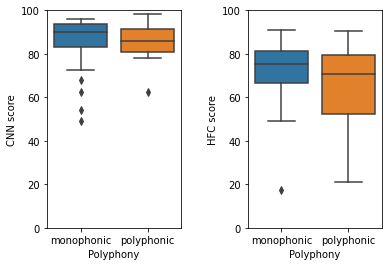

In [48]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, )
sns.boxplot(ax=axs[0], data=df, x="Polyphony", y="CNN score")
sns.boxplot(ax=axs[1], data=df, x="Polyphony", y="HFC score")
for ax in axs:
    ax.set_ylim(0,100)
plt.subplots_adjust(wspace=0.5)

In [66]:
df[["Name", "Energy per second", "CNN score", "HFC score"]]

,Name,Energy per second,CNN score,HFC score
0,slurtest01,765.361914,92.19,81.739130
1,slurtest02,688.232107,92.42,75.438596
2,slurtest03,726.440918,91.47,81.818182
3,slurtest04,843.397803,92.90,79.432624
4,slurtest05,503.857083,82.20,75.799087
5,slurtest06,431.209162,95.74,72.642968
6,slurtest07,335.340967,93.14,64.656616
7,slurtest08,805.162028,94.12,78.048780
8,slurtest09,639.469522,87.67,83.453237
9,slurtest10,321.257325,49.09,52.747253


Text(0.5, 0, 'Audio energy per second')

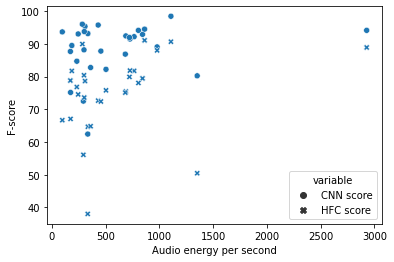

In [70]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=pd.melt(df[["Name", "Energy per second", "CNN score", "HFC score"]][df.Vibrato==0], ["Name", "Energy per second"]), x="Energy per second", y="value", style="variable")
ax.set_ylabel("F-score")
ax.set_xlabel("Audio energy per second")